In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
""" if(torch.cuda.is_available()):
    device = "cuda"
else:
    device = "cpu" """
device ="cpu"

In [104]:
data1=pd.read_csv("data/finbadtrb.csv")
data2=pd.read_csv("data/finbadtrg.csv")

data3=pd.read_csv("data/finbadvalb.csv")
data4=pd.read_csv("data/finbadvalg.csv")

data5=pd.read_csv("data/fingoodtrg.csv")
data6=pd.read_csv("data/fingoodvalg.csv")

data = pd.concat([data1,data2,data3,data4,data5,data6])
params=len(data.columns)-1

In [151]:
from sklearn.model_selection import train_test_split
print(data["Label"].value_counts())
print("test_size: ",len(data)*(1/3))
print("train_size: ",len(data)*(2/3))
X=data.drop(columns="Label")
y=data["Label"]
#scaler=MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("train label split\n",y_train.value_counts())
print("test label split\n",y_test.value_counts())

Label
0    1265
1     570
Name: count, dtype: int64
test_size:  611.6666666666666
train_size:  1223.3333333333333
train label split
 Label
0    857
1    372
Name: count, dtype: int64
test label split
 Label
0    408
1    198
Name: count, dtype: int64


In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import torch.utils
from pickle import dump
encoder = LabelEncoder()
data["Label"] = encoder.fit_transform(data["Label"])
X=data.drop(columns="Label").to_numpy(dtype=np.float32)
y=data["Label"].to_numpy(dtype=np.float32)
#scaler=MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

train_dataset= torch.utils.data.TensorDataset(torch.tensor(X_train),torch.tensor(y_train))

test_dataset= torch.utils.data.TensorDataset(torch.tensor(X_test),torch.tensor(y_test))
#dump(scaler, open('scaler.pkl', 'wb'))

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=16,num_workers=3)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=4,num_workers=3)

In [106]:

class slouch_detection(nn.Module):
    def __init__(self):
        super(slouch_detection,self).__init__()
        self.layers = nn.Sequential(
            nn.LayerNorm(params),
            nn.Linear(params,64),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.LayerNorm(64),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    @torch.compile(fullgraph=True, dynamic=True, options = {"epilogue_fusion": True, "max_autotune": True,
                    "shape_padding": True})
    def forward(self,x):
        return self.layers(x)


In [107]:
model = slouch_detection().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Assuming you're using Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # You can adjust the learning rate as needed


In [108]:
total=0
for params in model.parameters():
    total+=params.numel()
total

1511

In [109]:
train_losses=[]
train_acc=[]

test_losses=[]
test_accuracy=[]
def train_model(model, train_loader, optimizer, criterion, epochs,device,best_acc):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            labels=labels.unsqueeze(dim=1).to(device)
            outputs = model(inputs.to(device))
            #print(outputs.size(),labels.unsqueeze(dim=1).size())
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
            
            # Calculate accuracy
            predicted = torch.round(outputs)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            print()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        test_model(model, test_dataloader, criterion,device,best_acc)

# Testing loop
def test_model(model, test_loader, criterion,device,best_acc):
    model.eval()
    with torch.inference_mode():
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            labels=labels.unsqueeze(dim=1).to(device)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        test_loss = running_loss / len(test_loader.dataset)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        if(best_acc<test_acc):
            torch.save(model.state_dict(),"slouch_detector.pt")
            best_acc=test_acc
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [110]:

best_acc=0
epochs=50
train_model(model, train_dataloader, optimizer, criterion,device=device, epochs=epochs,best_acc=best_acc)  # Adjust epochs as needed















































































Epoch 1/50, Loss: 0.6117, Accuracy: 0.6827
Test Loss: 0.6030, Test Accuracy: 0.6617













































































Epoch 2/50, Loss: 0.5883, Accuracy: 0.6876
Test Loss: 0.5936, Test Accuracy: 0.6518













































































Epoch 3/50, Loss: 0.5776, Accuracy: 0.6876
Test Loss: 0.5840, Test Accuracy: 0.6518













































































Epoch 4/50, Loss: 0.5670, Accuracy: 0.6900
Test Loss: 0.5742, Test Accuracy: 0.6502













































































Epoch 5/50, Loss: 0.5556, Accuracy: 0.6867
Test Loss: 0.5654, Test Accuracy: 0.6535













































































Epoch 6/50, Loss: 0.5432, Accuracy: 0.6802
Test Loss: 0.5560, Test Accuracy: 0.6535




































50
50


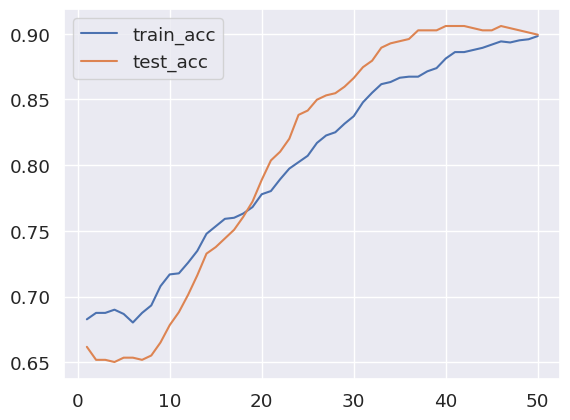

In [111]:
import matplotlib.pyplot as plt
# Create pandas DataFrames after training
train_df = pd.DataFrame({'Train Loss': train_losses, 'Train Accuracy': train_acc})
test_df = pd.DataFrame({'Test Loss': test_losses, 'Test Accuracy': test_accuracy})

# Print or plot the DataFrames (use libraries like matplotlib or seaborn for plotting)
""" print("Train Data:")
print(train_df.to_string())
print("\nTest Data:")
print(test_df.to_string()) """

# Access and use the confusion matrix (consider libraries like matplotlib or seaborn for visualization)
""" print("\nConfusion Matrix:")
print(confusion_matrix) """
print(len(train_losses))
print(len(train_acc))

#plt.plot(range(1,len(train_losses)+1),train_losses,)
plt.plot(range(1,len(train_acc)+1),train_acc,)
#plt.plot(range(1,len(test_losses)+1),test_losses,)
plt.plot(range(1,len(test_accuracy)+1),test_accuracy,)
#plt.plot(range(1,len(train_acc)+1),train_acc)
plt.legend(["train_acc","test_acc"])
#test_model(model, test_dataloader, criterion,device,best_acc)

In [112]:
# test_model(model, test_dataloader, criterion,device,best_acc)

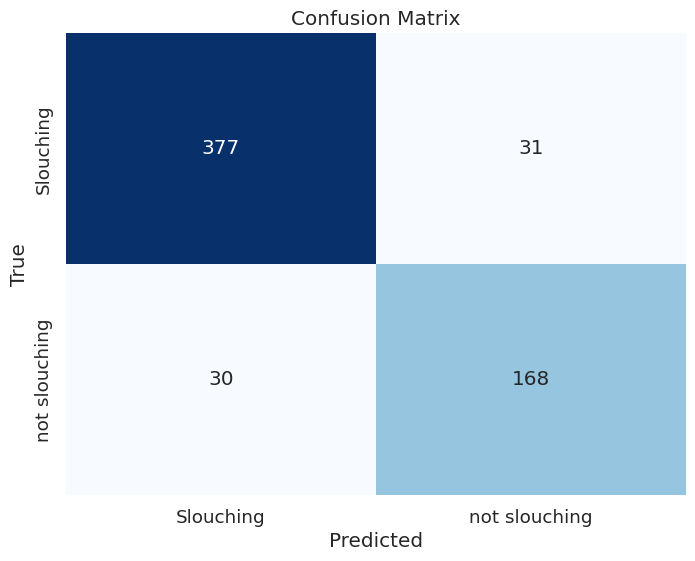

In [136]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a PyTorch model named 'model'
# and a test dataloader named 'test_dataloader'

def plot_confusion_matrix(model, test_dataloader, class_names):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model (CPU or GPU)

    all_true_labels = []
    all_pred_labels = []

    with torch.inference_mode():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            #print(outputs)
            # Get predicted labels
            predicted = torch.where(outputs<0.5,0,1)
            #print(predicted,labels)
            # Convert to numpy arrays and append to lists
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    confusion_mat = confusion_matrix(all_true_labels, all_pred_labels)

    # Plot confusion matrix as heatmap
    sns.set_palette("Blues")  # You can replace "Blues" with any other sequential palette
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
class_names = ["Slouching","not slouching"]  # Replace with your class names
plot_confusion_matrix(model, test_dataloader, class_names)
